# Introduction


<style>
OL { counter-reset: item }
LI { display: block }
LI:before { content: counters(item, ".") " "; counter-increment: item }
</style>

The dataset for this Sprint is the Ultimate 25k+ Matches Football Database. The main goal imposed by Turing College - explore the possibility to bet on Football matches. It is going to be a challenge to work with this large dataset, but our aim will be to find out what could make our bet successful. This project will consist of 3 major parts:

<ol>
    <li> EDA
    <ol>
        <li> Explore what leagues, teams and players score the most goals.
        <li> Analyse the time dynamics of football matches.
        <li> Explore the team attributes, trying to answer what makes a team perform better.
    </ol>
    <li> Statistical inference, dedicated to find out if there is such a thing as home advantage.
    <li> Modelling
    <ol>
        <li> Predict goals scored by the home or away team using:
        <ol>
            <li> Linear regression and one-hot encoding for the team id.
            <li> Linear regression and team attributes.
            <li> Logistic regression and team attributes
        </ol>
        <li> Predict match outcome using binomial and multinomial logistic regression.
        <li> Test the models in a betting game.
    </ol>
</ol>


# Project execution


## Import dependencies


In [1]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.proportion import proportion_confint, proportions_ztest
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    classification_report,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
)
import plotly.figure_factory as ff
from functions import *

## Setup database


In [2]:
duckdb.query("INSTALL sqlite; LOAD sqlite;")
duckdb.query("ATTACH 'database.sqlite' AS my_data (TYPE sqlite);")

duckdb.query("CREATE VIEW Country AS SELECT * FROM my_data.Country;")
duckdb.query("CREATE VIEW League AS SELECT * FROM my_data.League;")
duckdb.query("CREATE VIEW Match AS SELECT * FROM my_data.Match;")
duckdb.query("CREATE VIEW Player AS SELECT * FROM my_data.Player;")
duckdb.query(
    "CREATE VIEW Player_Attributes AS SELECT * FROM my_data.Player_Attributes;"
)
duckdb.query("CREATE VIEW Team AS SELECT * FROM my_data.Team;")
duckdb.query("CREATE VIEW Team_Attributes AS SELECT * FROM my_data.Team_Attributes;")

duckdb.query("""
    SELECT 'Country' AS table_name, COUNT(1) AS row_count 
    FROM Country

    UNION

    SELECT 'League' AS table_name, COUNT(1) AS row_count 
    FROM League

    UNION

    SELECT 'Team' AS table_name, COUNT(1) AS row_count 
    FROM Team

    UNION
    
    SELECT 'Team_Attributes' AS table_name, COUNT(1) AS row_count 
    FROM Team_Attributes

    UNION
    
    SELECT 'Player' AS table_name, COUNT(1) AS row_count 
    FROM Player
    
    UNION
    
    SELECT 'Player_Attributes' AS table_name, COUNT(1) AS row_count 
    FROM Player_Attributes

    UNION
    
    SELECT 'Match' AS table_name, COUNT(1) AS row_count 
    FROM Match
    """)

┌───────────────────┬───────────┐
│    table_name     │ row_count │
│      varchar      │   int64   │
├───────────────────┼───────────┤
│ Player            │     11060 │
│ Team_Attributes   │      1458 │
│ Team              │       299 │
│ League            │        11 │
│ Country           │        11 │
│ Player_Attributes │    183978 │
│ Match             │     25979 │
└───────────────────┴───────────┘

## EDA


We explore the columns of all the tables in data_look.ipynb since it's easier to later reference them when working on EDA and modelling.<br>
Let's check for duplicated rows.


In [3]:
for table in ["Match", "Player", "Team", "Player_Attributes", "Team_Attributes"]:
    print(
        f"duplicates in {table}:"
        f" {duckdb.query(f'SELECT id FROM {table}').to_df().duplicated().sum()}"
    )

duplicates in Match: 0
duplicates in Player: 0
duplicates in Team: 0


duplicates in Player_Attributes: 0
duplicates in Team_Attributes: 0


### Which leagues are in which countries?


In [4]:
duckdb.query("""
    SELECT l.name league, c.name country
    FROM League l
    INNER JOIN Country c
    ON l.country_id = c.id
""")

┌──────────────────────────┬─────────────┐
│          league          │   country   │
│         varchar          │   varchar   │
├──────────────────────────┼─────────────┤
│ Belgium Jupiler League   │ Belgium     │
│ England Premier League   │ England     │
│ France Ligue 1           │ France      │
│ Germany 1. Bundesliga    │ Germany     │
│ Italy Serie A            │ Italy       │
│ Netherlands Eredivisie   │ Netherlands │
│ Poland Ekstraklasa       │ Poland      │
│ Portugal Liga ZON Sagres │ Portugal    │
│ Scotland Premier League  │ Scotland    │
│ Spain LIGA BBVA          │ Spain       │
│ Switzerland Super League │ Switzerland │
├──────────────────────────┴─────────────┤
│ 11 rows                      2 columns │
└────────────────────────────────────────┘

### Which leagues score the most/fewest goals?


To answer this question, we will need to look at both the home and away scores in matches among different leagues and calculate "Goals per match" since there will be a different amount of matches between the leagues.


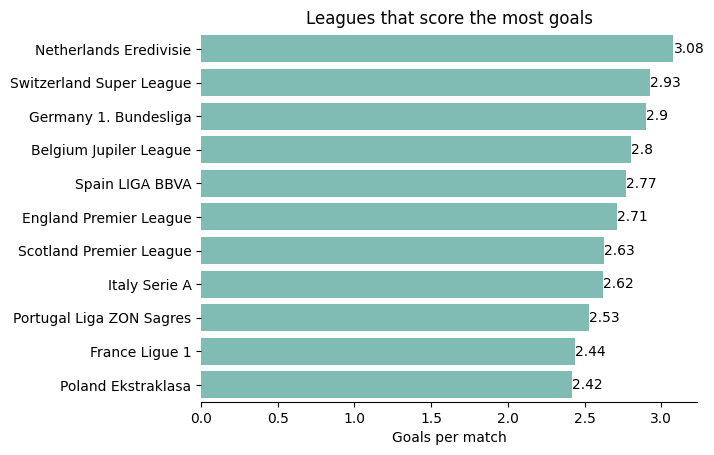

In [5]:
league_goals = duckdb.query("""
    SELECT L.name League, SUM(m.home_team_goal+m.away_team_goal) goals, COUNT(*) matches, ROUND(goals/matches,2) "Goals per match"
    FROM League L
    INNER JOIN Match m
    ON L.id = m.league_id
    GROUP BY L.name
    ORDER BY "Goals per match" DESC
""").to_df()

sns.barplot(data=league_goals, x="Goals per match", y="League", color=figure_colors[4])
plt.title("Leagues that score the most goals")
plt.ylabel("")
for container in plt.gca().containers:
    plt.gca().bar_label(container)
sns.despine(left=True)

Netherlands are the clear winner in this category.


### Top Teams compared by goals home and away


Which teams score the most goals? To answer this question we again need the goals per match metric. However, we also want to compare them by goals home and away, thus we need to record both of them.


In [6]:
team_goals_home = duckdb.query("""
    SELECT T.team_long_name AS 'Team', SUM(M.home_team_goal) AS Goals, COUNT(*) AS Matches, ROUND(goals/matches,2) AS "Goals per match"
    FROM League L
    FULL OUTER JOIN Match M
    ON L.id = M.league_id
    FULL OUTER JOIN Team T
    ON M.home_team_api_id = T.team_api_id
    GROUP BY L.name, T.team_long_name
""").to_df()

team_goals_away = duckdb.query("""
    SELECT T.team_long_name AS 'Team', SUM(M.away_team_goal) AS Goals, COUNT(*) AS Matches, ROUND(goals/matches,2) AS "Goals per match"
    FROM League L
    FULL OUTER JOIN Match M
    ON L.id = M.league_id
    FULL OUTER JOIN Team T
    ON M.home_team_api_id = T.team_api_id
    GROUP BY L.name, T.team_long_name
""").to_df()

# concatenate the home and away tables
team_goals = (
    team_goals_home[["Team", "Goals", "Matches", "Goals per match"]]
    .set_index("Team")
    .rename(
        {
            "Goals": "Goals home",
            "Matches": "Matches home",
            "Goals per match": "Goals per match home",
        },
        axis=1,
    )
)
team_goals[["Goals away", "Matches away", "Goals per match away"]] = team_goals_away[
    ["Team", "Goals", "Matches", "Goals per match"]
].set_index("Team")

Check if there's any team that have uneven home / away matches count.


In [7]:
(team_goals["Matches home"] != team_goals["Matches away"]).sum()

0

There are none, which means that the dataset is quite clean, capturing all the matches.


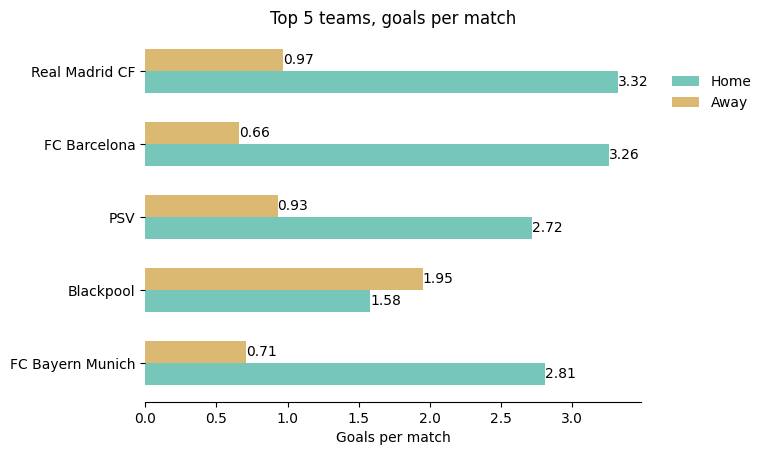

In [8]:
# calculate a unified metric to select the 5 best scoring teams
team_goals["Total goals per match"] = (
    team_goals["Goals home"] + team_goals["Goals away"]
) / (team_goals["Matches home"] * 2)
team_goals = team_goals.sort_values("Total goals per match", ascending=False)
team_goals_best = team_goals.head(5).sort_values(
    "Total goals per match", ascending=True
)

# create top5 scoring teams comparison figure
yticks = np.arange(5)
yticks_1st = yticks - 0.15
yticks_2nd = yticks + 0.15

bar1 = plt.barh(
    yticks_1st,
    team_goals_best["Goals per match home"],
    height=0.3,
    color=figure_colors[4],
    label="Home",
)
bar2 = plt.barh(
    yticks_2nd,
    team_goals_best["Goals per match away"],
    height=0.3,
    color=figure_colors[1],
    label="Away",
)
plt.gca().legend(bbox_to_anchor=(1.05, 0.9), borderaxespad=0.0, frameon=False)
plt.yticks(yticks, team_goals_best.index)
plt.title("Top 5 teams, goals per match")
plt.xlabel("Goals per match")
for container in plt.gca().containers:
    plt.gca().bar_label(container)
sns.despine(left=True)

Here we have the 5 best team when judging by the goals per match metric. Most of them score approximately 4 times more goals when playing home. Blackpool stands out, scoring slightly more goals when away.<br>
From business perspective, we need to watch out for these very strong teams as they have a very big advantage over the weaker teams.


### Who are the top scorers in each team and league?


#### Top 5 players in dataset


It is quite easy to find the best 5 scorers in the whole dataset. We can take the whole dataset and count how many goals each one scored.


In [9]:
goal_not_null = duckdb.query(
    "SELECT home_team_api_id, away_team_api_id, goal FROM Match WHERE goal IS NOT NULL"
).to_df()
goal_not_null[["home_scorers", "away_scorers"]] = goal_not_null.apply(
    extract_scorers, axis=1
)
player_goals_dict, _ = get_player_goal_counts(goal_not_null)

player_goals_ser = pd.Series(player_goals_dict)
player_goals_ser.describe()

count    4136.000000
mean        9.368230
std        16.491119
min         1.000000
25%         2.000000
50%         4.000000
75%        10.000000
max       295.000000
dtype: float64

In the whole dataset we have 4136 players who made at least one goal. The busiest player scored 295.


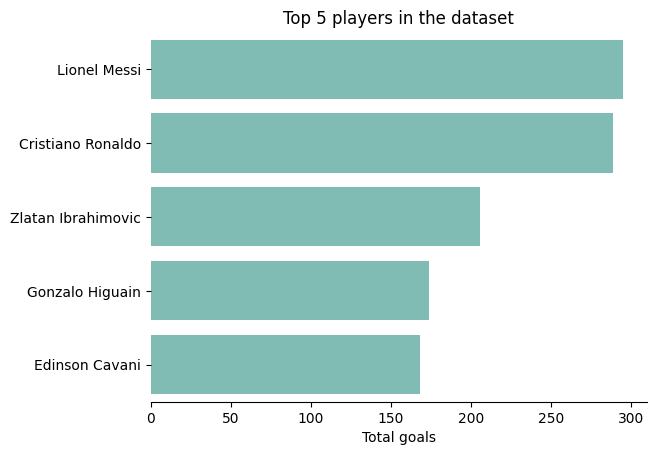

In [10]:
# setup player_api_id to player_name map
player_id_to_name = (
    duckdb.query("SELECT player_api_id, player_name FROM Player")
    .to_df()
    .set_index("player_api_id")
)
player_id_to_name.index = player_id_to_name.index.astype(int)

# associate player ids with goals and select top 5 players
player_goals_df = player_id_to_name.copy()
player_goals_df["goals"] = player_goals_ser
player_goals_df = player_goals_df.dropna()
player_goals_df["goals"] = player_goals_df["goals"].astype(int)
top5_players = player_goals_df.sort_values("goals", ascending=False).head(5)

sns.barplot(data=top5_players, x="goals", y="player_name", color=figure_colors[4])
plt.title("Top 5 players in the dataset")
plt.ylabel("")
plt.xlabel("Total goals")
sns.despine(left=True)

Unsurprisingly, we get the brightest football stars in this figure. The top 3 are no doubt known to even those who have zero interest in football.<br>
From business perspective, we may want to consider how experienced the players are constituting the playing teams. Best scorers not only score more, but also demoralise the opponent.


Export data for Google Looker Studio


In [11]:
# record data changing in time
looker_data_changing_time = duckdb.query("""
    SELECT P.player_api_id, P.player_name, PA.date, PA.overall_rating, PA.potential
    FROM Player_Attributes PA
    JOIN Player P
    ON P.player_api_id = PA.player_api_id
""").to_df()

# record data that shouldn't change in time
looker_data_static = duckdb.query("""
    SELECT DISTINCT P.player_api_id, P.player_name, P.height, P.weight, PA.preferred_foot
    FROM Player_Attributes PA
    JOIN Player P
    ON P.player_api_id = PA.player_api_id
""").to_df()

# process data
looker_data_static = looker_data_static.drop_duplicates("player_api_id").fillna("None")
looker_data_static = (
    pd.merge(
        looker_data_static,
        player_goals_df,
        how="outer",
        left_on="player_api_id",
        right_on="player_api_id",
    )
    .drop(columns=["player_name_y"])
    .rename(columns={"player_name_x": "player_name"})
    .fillna(0)
)
looker_data_changing_time = looker_data_changing_time.dropna()

# export csv
looker_data_static.to_csv("./looker_data_static.csv", index=False)
looker_data_changing_time.to_csv("./looker_data_changing_time.csv", index=False)

The Looker Studio dashboard can be found here: https://lookerstudio.google.com/reporting/51d1f099-c5bd-4dbf-96fd-f2db227abac2 <br>
Note! I experimented in the dashboard with blending data, which made it really slow to load even though the data is a bit less than 10 MB. Sorry!


#### Best players in Team and league


To get the best players in teams and leagues we need to first commit to a strategy. Since players frequently change teams, it is futile to take the whole dataset. This time, let's analyse only the last season in the dataset and drop any players that have changed team mid-season.


In [12]:
goal_not_null_2016 = duckdb.query(
    "SELECT home_team_api_id, away_team_api_id, goal FROM Match WHERE goal IS NOT NULL"
    " AND season='2015/2016'"
).to_df()
goal_not_null_2016[["home_scorers", "away_scorers"]] = goal_not_null_2016.apply(
    extract_scorers, axis=1
)
player_goals_dict_2016, player_teams_dict_2016 = get_player_goal_counts(
    goal_not_null_2016
)
player_goals_df_2016 = pd.DataFrame(
    [player_teams_dict_2016, player_goals_dict_2016]
).T.rename({0: "team_api_id", 1: "goals"}, axis=1)

Number of players that switched team mid-season


In [13]:
(player_goals_df_2016["team_api_id"] == -1).sum()

33

There are a few. If we looked at how many goals these players scored this season, the max would be 13, which we will see doesn't compete with the best scorers.


Finally, let's look at the best players in the leagues.


In [14]:
# Create team_api_id to league and team map
teams_and_leagues = duckdb.query("""
    SELECT DISTINCT L.name AS 'league', M.away_team_api_id, T.team_long_name AS 'team'
    FROM Match M
    INNER JOIN League L
    ON M.league_id = L.id
    INNER JOIN Team T
    ON M.away_team_api_id = T.team_api_id
""").to_df().set_index("away_team_api_id")
teams_and_leagues.index = teams_and_leagues.index.astype(int)

# pull the names of teams, leagues and players
player_goals_df_2016["player_api_id"] = player_goals_df_2016.index
player_goals_df_2016 = player_goals_df_2016.set_index("team_api_id")
player_goals_df_2016 = player_goals_df_2016.join(
    teams_and_leagues, how="inner"
).set_index("player_api_id")
player_goals_df_2016["player_name"] = player_id_to_name["player_name"]

best_in_league_idx = (
    player_goals_df_2016.groupby(["league"])["goals"].transform(max)
    == player_goals_df_2016["goals"]
)
player_goals_df_2016[best_in_league_idx].sort_values("goals", ascending=False)

,goals,league,team,player_name
player_api_id,,,,
40636,42,Spain LIGA BBVA,FC Barcelona,Luis Suarez
35724,41,France Ligue 1,Paris Saint-Germain,Zlatan Ibrahimovic
25759,36,Italy Serie A,Napoli,Gonzalo Higuain
93447,31,Germany 1. Bundesliga,FC Bayern Munich,Robert Lewandowski
150201,28,Netherlands Eredivisie,PSV,Luuk de Jong
467022,28,Netherlands Eredivisie,AZ,Vincent Janssen
286119,25,England Premier League,Leicester City,Jamie Vardy
37412,25,England Premier League,Manchester City,Sergio Aguero
194165,25,England Premier League,Tottenham Hotspur,Harry Kane


Also, we can analyse the best players in the teams, but since there's quite a few teams, lets look at top 20 scores.


In [15]:
best_in_team_idx = (
    player_goals_df_2016.groupby(["team"])["goals"].transform(max)
    == player_goals_df_2016["goals"]
)
player_goals_df_2016[best_in_team_idx].sort_values("goals", ascending=False).head(20)

,goals,league,team,player_name
player_api_id,,,,
40636,42,Spain LIGA BBVA,FC Barcelona,Luis Suarez
35724,41,France Ligue 1,Paris Saint-Germain,Zlatan Ibrahimovic
30893,39,Spain LIGA BBVA,Real Madrid CF,Cristiano Ronaldo
25759,36,Italy Serie A,Napoli,Gonzalo Higuain
93447,31,Germany 1. Bundesliga,FC Bayern Munich,Robert Lewandowski
150201,28,Netherlands Eredivisie,PSV,Luuk de Jong
467022,28,Netherlands Eredivisie,AZ,Vincent Janssen
150565,26,Germany 1. Bundesliga,Borussia Dortmund,Pierre-Emerick Aubameyang
194165,25,England Premier League,Tottenham Hotspur,Harry Kane


All in all, there are quite a few talented players and we may benefit from tracking their statistics.


### Analyse match dynamics in time


From business perspective, it is quite interesting to see how european football's popularity is changing over time.


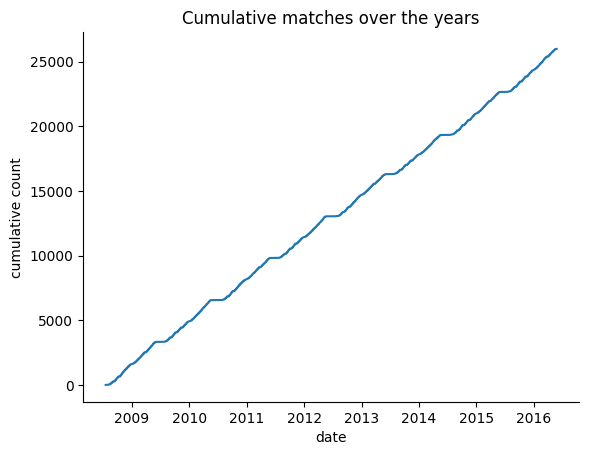

In [16]:
cumulative_matches = duckdb.query("""
                                 WITH grouped AS(
                                    SELECT strptime(date, '%c') AS match_date,
                                    COUNT(1) AS 'count'
                                    FROM MATCH
                                    GROUP BY match_date
                                 )
                                 SELECT match_date, 
                                 SUM(count) OVER (ORDER BY match_date) AS 'matches'
                                 FROM grouped
""").to_df()

sns.lineplot(
    cumulative_matches.set_index("match_date"), legend=None, color=figure_colors[4]
)
plt.title("Cumulative matches over the years")
plt.ylabel("cumulative count")
plt.xlabel("date")
sns.despine()

We can see that roughly the matches have been going on in a steady manner. There're just a few months during which there are no matches played.


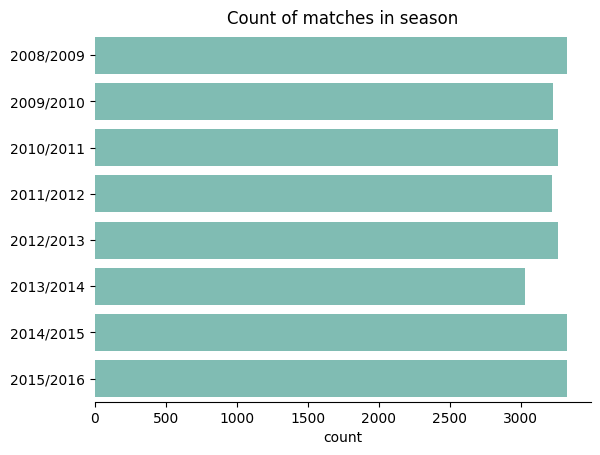

In [17]:
season_matches = duckdb.query("""
             SELECT season, COUNT(1) AS count
             FROM MATCH
             GROUP BY season
""").to_df()

sns.barplot(season_matches, x="count", y="season", color=figure_colors[4])
plt.title("Count of matches in season")
plt.ylabel("")
sns.despine(left=True)

From the above graph we can see that there're in fact little fluctuation in the amount of games played per season, which would imply the football popularity should be quite stable.


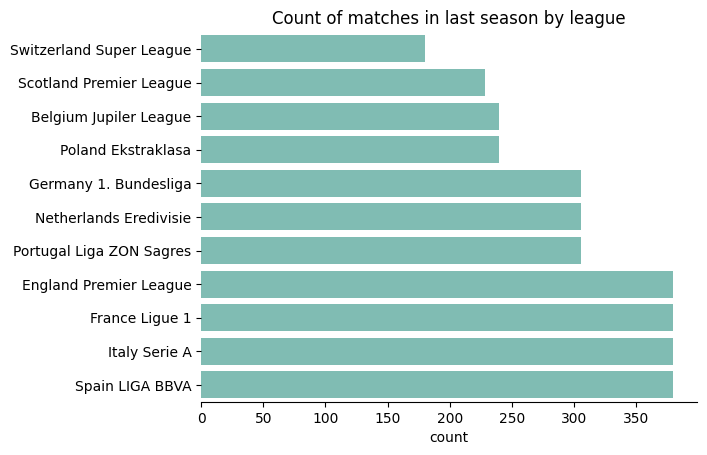

In [18]:
last_season_matches = duckdb.query("""
                                   SELECT L.name AS league, COUNT(1) AS count
                                   FROM MATCH M
                                   JOIN League L
                                   ON M.league_id = L.id
                                   WHERE M.season = '2015/2016'
                                   GROUP BY L.name
                                   ORDER BY count
""").to_df()

sns.barplot(last_season_matches, x="count", y="league", color=figure_colors[4])
plt.title("Count of matches in last season by league")
plt.ylabel("")
sns.despine(left=True)

There are a few leagues that have many more matches played And we could imply that these are the countries that have the most involved football fans. If we wanted to more deeply analyse league by league, these 4 leagues would be a good start.


### Team data EDA


There are a pair levels of granularity that we can select to analyse the strength of a team - the lowest level being the players. The higher level is the team, whose parameters should stay quite stable provided it has a stable budget. Let's try taking a glimpse at the latter level, which should be less tedious to analyse.


In [19]:
team_data = duckdb.query("""
    SELECT T.team_long_name AS team, TA.*
    FROM Team_Attributes TA
    JOIN Team T
    ON T.team_api_id = TA.team_api_id
""").to_df()
team_data["date_parsed"] = pd.to_datetime(team_data["date"])
team_data = team_data.drop(
    columns=[
        "date",
        "id",
        "team_fifa_api_id",
    ]
)
print(f"Total entries in the Team_Attributes table: {len(team_data)}")

Total entries in the Team_Attributes table: 1458


Let's look if there are any null values.


In [20]:
team_data.isnull().sum()

team                                0
team_api_id                         0
buildUpPlaySpeed                    0
buildUpPlaySpeedClass               0
buildUpPlayDribbling              969
buildUpPlayDribblingClass           0
buildUpPlayPassing                  0
buildUpPlayPassingClass             0
buildUpPlayPositioningClass         0
chanceCreationPassing               0
chanceCreationPassingClass          0
chanceCreationCrossing              0
chanceCreationCrossingClass         0
chanceCreationShooting              0
chanceCreationShootingClass         0
chanceCreationPositioningClass      0
defencePressure                     0
defencePressureClass                0
defenceAggression                   0
defenceAggressionClass              0
defenceTeamWidth                    0
defenceTeamWidthClass               0
defenceDefenderLineClass            0
date_parsed                         0
dtype: int64

buildUpPlayDribbling feature stands out as having a lot of NAs. Let's look how many teams have at least one entry of the feature.


In [21]:
teams_with_dribbling_cnt = len(duckdb.query("""
    SELECT DISTINCT T.team_long_name
    FROM Team_Attributes TA
    JOIN Team T
    ON T.team_api_id = TA.team_api_id
    WHERE TA.buildUpPlayDribbling IS NOT NULL
""").to_df())

teams_with_attributes_cnt = len(duckdb.query("""
    SELECT DISTINCT T.team_long_name
    FROM Team_Attributes TA
    JOIN Team T
    ON T.team_api_id = TA.team_api_id
""").to_df())

all_teams_cnt = len(duckdb.query("""
    SELECT DISTINCT T.team_long_name
    FROM Team T
    ORDER BY T.team_long_name
""").to_df())
print(
    f"There are {all_teams_cnt} teams in total {teams_with_attributes_cnt} of which"
    f" have their attributes recorded.\nOnly {teams_with_dribbling_cnt} teams have at"
    " least one entry for the buildUpPlayDribbling feature."
)

There are 296 teams in total 285 of which have their attributes recorded.
Only 260 teams have at least one entry for the buildUpPlayDribbling feature.


Since there are teams that have no history of buildUpPlayDribbling feature, it may be safest to drop the feature.


In [22]:
team_data = team_data.drop(columns=["buildUpPlayDribbling"])

To find out what attributes make a team win more, we can calculate the teams score and performance.<br>
Score will be calculated as follows: 3 points awarded for win, 0 for loss, 1 for tie - that's how league scoring works.<br>
Performance will be calculated as follows: bottom 25% are low performers, middle 50% - medium, top 25% - high.


In [23]:
team_scores = duckdb.query("""
    WITH home_outcomes AS (
        SELECT T.team_long_name AS team,
        CASE
            WHEN home_team_goal > away_team_goal THEN 3
            WHEN home_team_goal < away_team_goal THEN 0
            ELSE 1
        END AS outcome
        FROM Match M
        JOIN Team T
        ON T.team_api_id = M.home_team_api_id
    ),
    away_outcomes AS (
        SELECT T.team_long_name AS team,
        CASE
            WHEN away_team_goal > home_team_goal THEN 3
            WHEN away_team_goal < home_team_goal THEN 0
            ELSE 1
        END AS outcome
        FROM Match M
        JOIN Team T
        ON T.team_api_id = M.away_team_api_id
    ),
    home_scores AS (
        SELECT team, SUM(outcome) AS score
        FROM home_outcomes
        GROUP BY team
    ),
    away_scores AS (
        SELECT team, SUM(outcome) AS score
        FROM away_outcomes
        GROUP BY team
    )
    SELECT H.team, H.score+A.score AS total_score
    FROM home_scores H
    JOIN away_scores A
    ON H.team = A.team
    ORDER BY total_score DESC
""").to_df()

# create performance filters
quantile25 = team_scores["total_score"].quantile(0.25)
quantile75 = team_scores["total_score"].quantile(0.75)
low_performers = team_scores["total_score"] < quantile25
med_performers = (team_scores["total_score"] >= quantile25) & (
    team_scores["total_score"] < quantile75
)
high_performers = team_scores["total_score"] >= quantile75

# assign performance
team_scores["performance"] = None
team_scores.loc[low_performers, "performance"] = "low"
team_scores.loc[med_performers, "performance"] = "medium"
team_scores.loc[high_performers, "performance"] = "high"

# assign the processed data onto team data, keep only the latest entry
team_data = pd.merge(team_data, team_scores, how="inner", on="team")
latest_team_data = team_data.sort_values("date_parsed").drop_duplicates(
    "team", keep="last"
)
print("The freshest Team_Attributes data:")
latest_team_data["date_parsed"].max()

The freshest Team_Attributes data:


Timestamp('2015-09-10 00:00:00')

We will be analysing only the most up-to-date team attributes. The last update was done on 2015-09-10.


In [24]:
latest_team_data.describe(include=[object]).iloc[:, :7]

,team,buildUpPlaySpeedClass,buildUpPlayDribblingClass,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassingClass,chanceCreationCrossingClass
count,285,285,285,285,285,285,285
unique,285,3,3,3,2,3,3
top,Odra Wodzisław,Balanced,Normal,Mixed,Organised,Normal,Normal
freq,1,256,232,263,275,254,256


In [25]:
latest_team_data.describe(include=[object]).iloc[:, 7:]

,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressureClass,defenceAggressionClass,defenceTeamWidthClass,defenceDefenderLineClass,performance
count,285,285,285,285,285,285,285
unique,3,2,3,3,3,2,3
top,Normal,Organised,Medium,Press,Normal,Cover,medium
freq,250,259,258,269,273,280,148


Most of the categorical features may be problematic to implement in a model, since most of them have a very dominant category. However, there should be plenty of matches so let's hope it will not be a problem.


In [26]:
latest_team_data.sort_values("buildUpPlaySpeed")[
    ["buildUpPlaySpeed", "buildUpPlaySpeedClass"]
]

,buildUpPlaySpeed,buildUpPlaySpeedClass
1316,29,Slow
960,30,Slow
246,30,Slow
1055,30,Slow
554,31,Slow
...,...,...
1094,70,Fast
492,71,Fast
486,73,Fast
132,77,Fast


We can see that the "Class" features actually are binned categories of the features without "Class" at the end. We would probably not want to include both of these feature pairs in our modelling.<br>
We can notice that there are several binned features that have no "Class-less" counterpart.


In [27]:
class_features = [
    "buildUpPlayDribblingClass",
    "buildUpPlayPositioningClass",
    "chanceCreationPositioningClass",
    "defenceDefenderLineClass",
]

Let's analyse these features with regards to teams' performance.


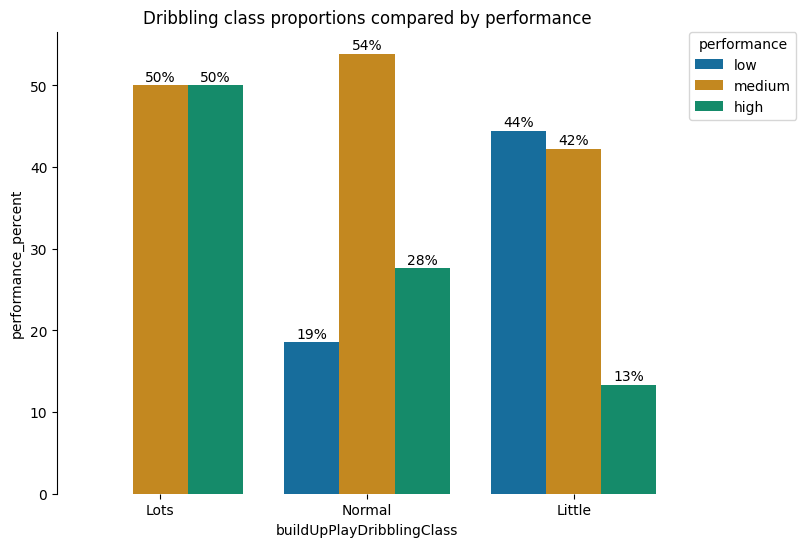

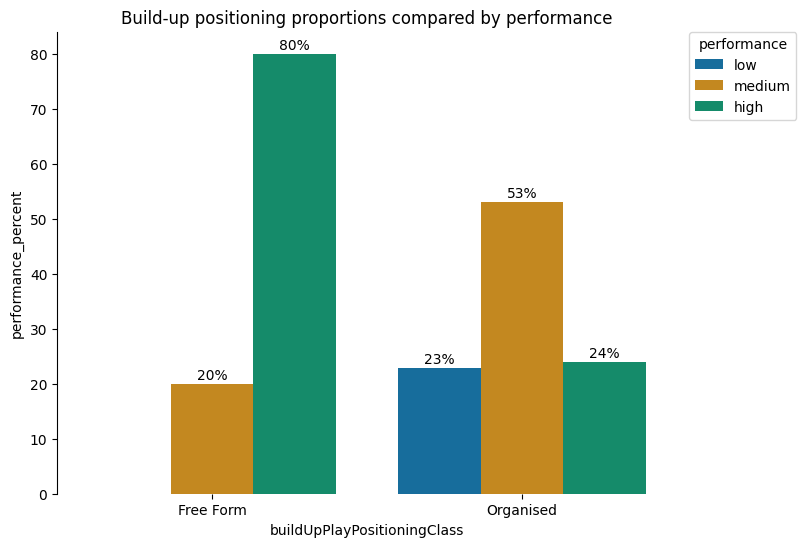

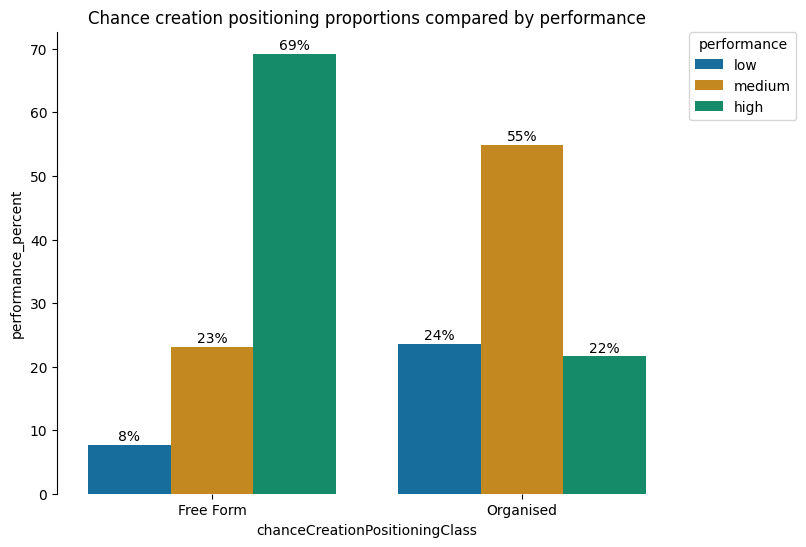

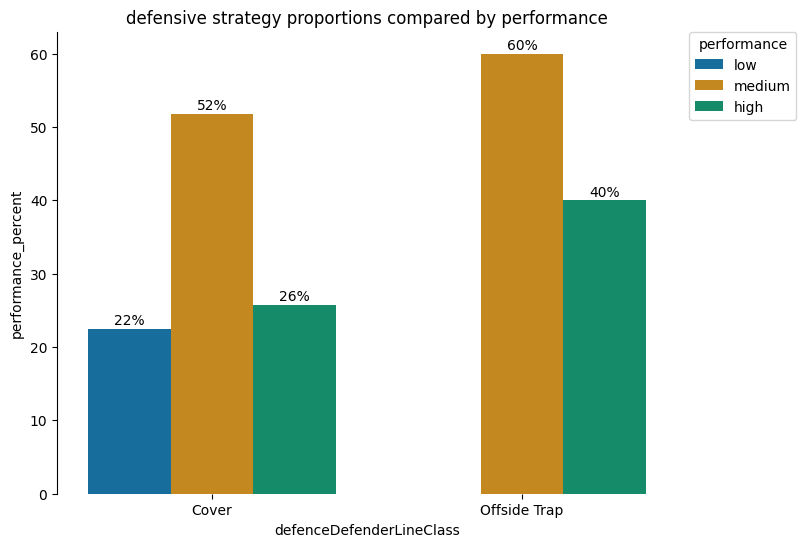

In [28]:
hue_order = ["low", "medium", "high"]
percent_plot(
    latest_team_data,
    x=class_features[0],
    hue="performance",
    title="Dribbling class proportions compared by performance",
    order=["Lots", "Normal", "Little"],
    palette=figure_colors_qualitative,
    hue_order=hue_order,
)
plt.figure()
percent_plot(
    latest_team_data,
    x=class_features[1],
    hue="performance",
    title="Build-up positioning proportions compared by performance",
    palette=figure_colors_qualitative,
    hue_order=hue_order,
)
plt.figure()
percent_plot(
    latest_team_data,
    x=class_features[2],
    hue="performance",
    title="Chance creation positioning proportions compared by performance",
    palette=figure_colors_qualitative,
    hue_order=hue_order,
)
plt.figure()
percent_plot(
    latest_team_data,
    x=class_features[3],
    hue="performance",
    title="defensive strategy proportions compared by performance",
    palette=figure_colors_qualitative,
    hue_order=hue_order,
)

From these proportion plots we can pick up some features that make the best teams stand out: lots of dribbling, free form positioning and offside trap defensive strategies. However, we need to keep in mind that most teams are in the "normal", "organised", "organised", "cover" categories respectively to the order of the plots and, for example, there are just 5 teams who employ offside trap defensive strategy instead of cover.


Having analysed the categorical, let's check out the numerical features, too.


In [29]:
latest_team_data_numeric = latest_team_data.select_dtypes(include=[np.number])
latest_team_data_numeric.drop(columns=["team_api_id"]).describe()

,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,total_score
count,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000
mean,53.308772,49.568421,51.873684,52.954386,50.571930,45.431579,48.403509,51.491228,249.182456
std,9.557982,9.579526,9.732596,9.779327,10.379044,9.086036,8.398230,7.880540,173.226776
min,29.000000,20.000000,28.000000,26.000000,22.000000,25.000000,24.000000,29.000000,20.000000
25%,48.000000,43.000000,47.000000,48.000000,45.000000,39.000000,43.000000,48.000000,93.000000
50%,53.000000,50.000000,52.000000,53.000000,52.000000,45.000000,47.000000,52.000000,230.000000
75%,60.000000,55.000000,58.000000,60.000000,57.000000,51.000000,54.000000,56.000000,369.000000
max,80.000000,77.000000,77.000000,80.000000,80.000000,72.000000,72.000000,73.000000,745.000000


Looking at the table, we can say that these "numeric" values are all scores in a field. In that sense, they are ordinal features. However, since the range is quite vast, looks like [0:100], we will try treating them as numeric.


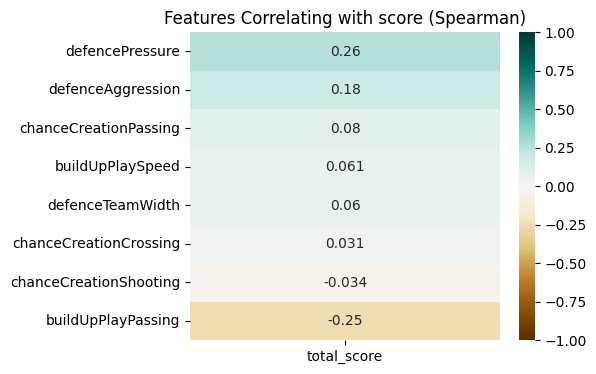

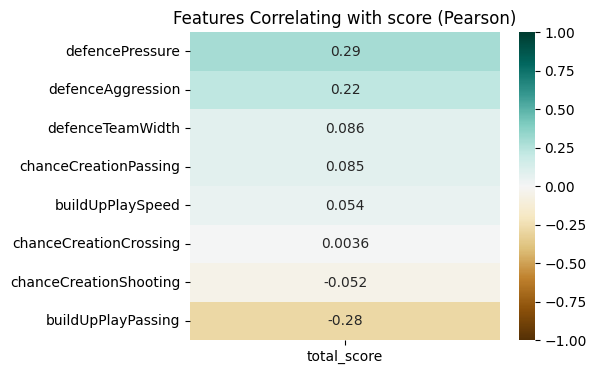

In [30]:
correlation_bar(
    latest_team_data_numeric.drop(columns=["team_api_id"]),
    "total_score",
    "Features Correlating with score (Spearman)",
    "spearman",
)
correlation_bar(
    latest_team_data_numeric.drop(columns=["team_api_id"]),
    "total_score",
    "Features Correlating with score (Pearson)",
    "pearson",
)

There are several features that have a great impact on the performance of the teams. We'll scatterplot some of them.


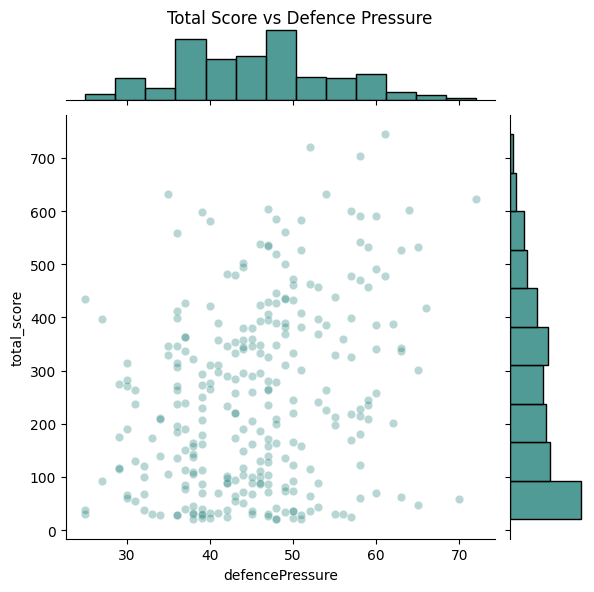

In [31]:
joint_scatterplot_with_title(
    "Total Score vs Defence Pressure",
    x=latest_team_data["defencePressure"],
    y=latest_team_data["total_score"],
    color=figure_colors[5],
)

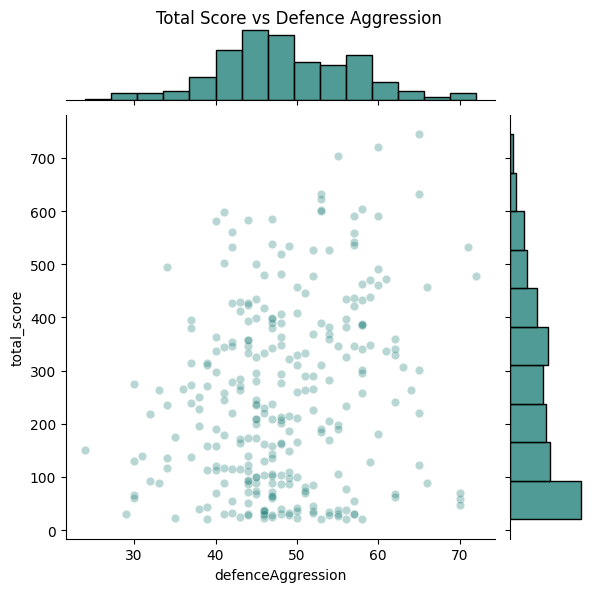

In [32]:
joint_scatterplot_with_title(
    "Total Score vs Defence Aggression",
    x=latest_team_data["defenceAggression"],
    y=latest_team_data["total_score"],
    color=figure_colors[5],
)

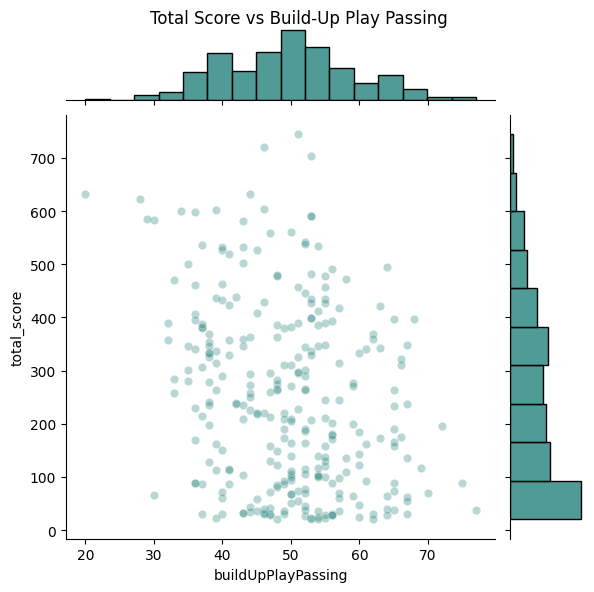

In [33]:
joint_scatterplot_with_title(
    "Total Score vs Build-Up Play Passing",
    x=latest_team_data["buildUpPlayPassing"],
    y=latest_team_data["total_score"],
    color=figure_colors[5],
)

First thing we can notice is that the correlations are quite evident in the scatterplots. Also, while the team attributes look quite normally spread out, score is for sure not - there are just a few teams that have a very good score. This heavy skew may also appear because there are some teams in the dataset which are newer or were disbanded at some point. Thus, we may want to more deeply look at the more recent seasons, but not at more old ones.


## Statistical inference


### Is there such a thing as home advantage?


#### Home team wins proportion


As seen in EDA subsection "Top Teams compared by goals home and away", it seems to be true that teams playing at home possess some kind of advantage. To be sure, we can perform statistical inference tests. One such test could be to see what proportion games end in home win rather than a away win.<br>
Population: all matches in dataset, excluding those that ended in ties.<br>
Null: the home wins to all matches except ties proportion is equal to 0.5.<br>
Alternative: proportion is bigger than 0.5.


In [34]:
population = duckdb.query("""
    SELECT CASE
        WHEN home_team_goal = away_team_goal THEN 'tie'
        WHEN home_team_goal > away_team_goal THEN 'home'
        WHEN home_team_goal < away_team_goal THEN 'away'
    END AS winner
    FROM Match
""").to_df()
population = population[population["winner"] != "tie"].dropna()
population.value_counts()

winner
home      11917
away       7466
Name: count, dtype: int64

After fetching the population, it is apparent that there are many more home wins. Let perform a one proportion Z test.


In [35]:
successes = (population["winner"] == "home").sum()
observations = len(population)
zvalue, pvalue = proportions_ztest(
    successes, observations, value=0.5, alternative="larger"
)
low, high = proportion_confint(successes, observations, alpha=0.05)

print(f"z-value: {zvalue:3.2f}")
print(f"p-value: {pvalue:1.3f}")
print(
    "home team wins to all matches except ties proportion estimate:"
    f" {successes/observations:1.2f}"
)
print(f"95% confidence interval: [{low:1.3f}; {high:1.3f}]")

z-value: 32.85
p-value: 0.000
home team wins to all matches except ties proportion estimate: 0.61
95% confidence interval: [0.608; 0.622]


The results state that we are fairly certain that the teams have a home advantage.


#### Mean goals scored


We can look at the home advantage differently: do teams score more goals when at home?<br>
Population: all matches in dataset, the amount of goals scored by home an away teams.<br>
Null: the mean goals scored by home and away teams is the same.<br>
Alternative: the mean is bigger for home teams.


In [36]:
population = duckdb.query("""
    SELECT home_team_goal AS home, away_team_goal AS away
    FROM Match
""").to_df()
population.sum(axis=0)

home    40127
away    30160
dtype: int64

Again, straight away we can notice there are far more goals scored at home. For statistical inference, we should be conducting a two sample t-test.


To conduct a parametric two sample t-test, there's several assumptions:

<ol>
<li> Variables should be continuous.
<li> Sample data is sampled randomly.
<li> Variance is homogeneous.
<li> Distributions are approximately normal.
</ol><br>
Immediately we can see some problems with conducting the test - goals per match is a discrete variable. We could still conduct the test to look what the outcome would be, but we may want to choose a non-parametric test for this.


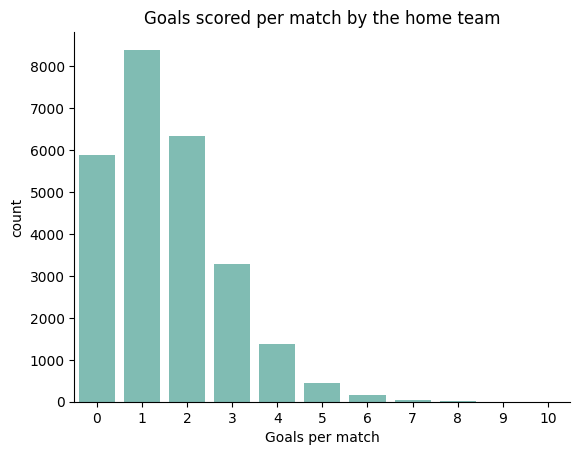

In [37]:
sns.countplot(x="home", data=population, color=figure_colors[4])
plt.xlabel("Goals per match")
plt.title("Goals scored per match by the home team")
sns.despine()

The distribution is skewed to the right since the distribution is cut-off at 0. Normality does not hold, but the skew is not very big given the sample size.


One of the t-test assumptions is that the samples are independent. However, we are sampling from the same matches dataset, where one goal count may influence the other. Thus, let's calculate the correlation.


In [38]:
pearson, pvalue = stats.pearsonr(population["home"], population["away"])
print(f"Pearson coefficient for the home - away goals: {pearson:1.2f}")
print(f"p value for the test: {pvalue:1.3f}")
spearman, pvalue = stats.spearmanr(population["home"], population["away"])
print(f"Spearman coefficient for the home - away goals: {spearman:1.2f}")
print(f"p value for the test: {pvalue:1.3f}")

Pearson coefficient for the home - away goals: -0.06
p value for the test: 0.000
Spearman coefficient for the home - away goals: -0.05
p value for the test: 0.000


The correlation is negligible. Let's continue with the t-test.


In [39]:
t, p = stats.ttest_ind(
    population["home"],
    population["away"],
    axis=0,
    equal_var=False,
    alternative="greater",
)
(low_home, high_home) = sms.DescrStatsW(population["home"]).tconfint_mean()
(low_away, high_away) = sms.DescrStatsW(population["away"]).tconfint_mean()

print(f"""
    t-stat: {t:2.2f}
    p-value: {p:1.3f}
    home team mean goals estimate: {population["home"].mean():1.3f}
    away team mean goals estimate: {population["away"].mean():1.3f}
    ci 95% for home team: [{low_home:1.3f}, {high_home:1.3f}]
    ci 95% for away team: [{low_away:1.3f}, {high_away:1.3f}]
    """)


    t-stat: 35.78
    p-value: 0.000
    home team mean goals estimate: 1.545
    away team mean goals estimate: 1.161
    ci 95% for home team: [1.529, 1.560]
    ci 95% for away team: [1.147, 1.175]
    


As in our one proportion test, the statistic value is very large. Looking at the confidence intervals, there's a huge gap between the two groups, rejecting the null. Still, for correctness let's also conduct a non-parametric test.


In [40]:
population_table = pd.concat(
    [population["home"].value_counts(), population["away"].value_counts()], axis=1
)
population_table.columns = ["home", "away"]
population_table = population_table.fillna(0)

chi, pval, _, _ = stats.chi2_contingency(population_table)
print(f"chi2 statistic: {chi:.2f}")
print(f"p-value: {pval:.3f}")

chi2 statistic: 1281.35
p-value: 0.000


With this final test, we can state that with 95% confidence the mean goals scored by home team is significantly higher than mean goals scored by the away team. Moreover, we have sufficient evidence to say that there is such a thing as home advantage.


## Modelling


### Can we predict how many goals each team will score in each match?


Train test split will be done on the date. The split is approximately 90:10 when the split is done on '2015-10-01' and we will use it as the splitting point here.


In [41]:
train_test_split_point = "2015-10-01"

#### Use dummies for home and away teams


We will start with building linear regression models.<bR>
In this section we will be using one-hot encoding for the home and away teams api id. Since each of the teams has a unique id, that would give 200+ features if all leagues were analysed at once. But since there should be no matches recorded between teams of two leagues, we could have different models for each of the leagues. Let's start with the England league and see how it goes.


In [42]:
X_train = duckdb.query("""
                       SELECT M.home_team_api_id, M.away_team_api_id, strptime(M.date, '%c') match_date
                       FROM MATCH M
                       JOIN League L
                       ON M.league_id = L.id
                       WHERE L.name = 'England Premier League' AND match_date < DATE '2015-10-01'
                       ORDER BY match_date
""").to_df()
X_test = duckdb.query("""
                       SELECT M.home_team_api_id, M.away_team_api_id, strptime(M.date, '%c') match_date
                       FROM MATCH M
                       JOIN League L
                       ON M.league_id = L.id
                       WHERE L.name = 'England Premier League' AND match_date >= DATE '2015-10-01'
                       ORDER BY match_date
""").to_df()

Y_train = duckdb.query("""
                       SELECT M.home_team_goal, M.away_team_goal, strptime(M.date, '%c') match_date
                       FROM MATCH M
                       JOIN League L
                       ON M.league_id = L.id
                       WHERE L.name = 'England Premier League' AND match_date < DATE '2015-10-01'
                       ORDER BY match_date
""").to_df().drop(columns=["match_date"])
Y_test = duckdb.query("""
                       SELECT M.home_team_goal, M.away_team_goal, strptime(M.date, '%c') match_date
                       FROM MATCH M
                       JOIN League L
                       ON M.league_id = L.id
                       WHERE L.name = 'England Premier League' AND match_date >= DATE '2015-10-01'
                       ORDER BY match_date
""").to_df().drop(columns=["match_date"])

print(f"We have {len(X_train)} entries in the train set.")
print(f"We have {len(X_test)} entries in the test set.")
print(
    "The (test:whole dataset) ratio is approximately"
    f" {len(X_test)/(len(X_test)+len(X_train)):.2f}"
)

We have 2730 entries in the train set.
We have 310 entries in the test set.
The (test:whole dataset) ratio is approximately 0.10


In [43]:
# split home and away goals
Y_train_home = Y_train["home_team_goal"]
Y_train_away = Y_train["away_team_goal"]
Y_test_home = Y_test["home_team_goal"]
Y_test_away = Y_test["away_team_goal"]

# get dummies for the X set
home_dums_train = pd.get_dummies(X_train["home_team_api_id"], "home", drop_first=True)
away_dums_train = pd.get_dummies(X_train["away_team_api_id"], "away", drop_first=True)
home_dums_test = pd.get_dummies(X_test["home_team_api_id"], "home", drop_first=True)
away_dums_test = pd.get_dummies(X_test["away_team_api_id"], "away", drop_first=True)
X_train = pd.concat([home_dums_train, away_dums_train], axis=1)
X_test = pd.concat([home_dums_test, away_dums_test], axis=1)
# ensure that testing dataset has identical columns. Question for corrector - How should this be correctly handled?
X_test = pd.DataFrame(X_test, columns=X_train.columns).fillna(False)

# scale X, fit the model
scaler = StandardScaler()
model = LinearRegression()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
model_home = model.fit(X_train_scaled, Y_train_home)
# validate the model
Y_predictions_home = model_home.predict(X_test_scaled)
RMSE = np.sqrt(mean_squared_error(Y_test_home, Y_predictions_home))
r2 = r2_score(Y_test_home, Y_predictions_home)
print("Validation metrics of the home model:")
print(f"RMSE: {RMSE:1.3f}")
print(f"r2: {r2:1.3f}")

Validation metrics of the home model:
RMSE: 1.304
r2: -0.035


In [44]:
model_away = model.fit(X_train_scaled, Y_train_away)
Y_predictions_away = model_away.predict(X_test_scaled)

RMSE = np.sqrt(mean_squared_error(Y_test_away, Y_predictions_away))
r2 = r2_score(Y_test_away, Y_predictions_away)
print("Validation metrics of the away model:")
print(f"RMSE: {RMSE:1.3f}")
print(f"r2: {r2:1.3f}")

Validation metrics of the away model:
RMSE: 1.193
r2: -0.078


For both the home and away models R squared is negative, which indicates a very bad model.<br>
We may want to explore other info in the dataset we have.


#### Use team attributes


This time, let's describe the home and away teams by their team attributes. For simplicity, we'll always use the latest team attributes, even though they may change over the course of time. Also, the latest team attributes are dated '2015-09-10' and our test set starts at '2015-10-01', which means there's no info leakage. However, we'll want to recalculate total_score not considering any "Future" matches in our test set.


In [45]:
# re-query team_score without leaking future info
team_scores = duckdb.query(f"""
    WITH home_outcomes AS (
        SELECT T.team_long_name AS team,
        CASE
            WHEN home_team_goal > away_team_goal THEN 3
            WHEN home_team_goal < away_team_goal THEN 0
            ELSE 1
        END AS outcome
        FROM Match M
        JOIN Team T
        ON T.team_api_id = M.home_team_api_id
        WHERE strptime(M.date, '%c') < DATE '{train_test_split_point}'
    ),
    away_outcomes AS (
        SELECT T.team_long_name AS team,
        CASE
            WHEN away_team_goal > home_team_goal THEN 3
            WHEN away_team_goal < home_team_goal THEN 0
            ELSE 1
        END AS outcome
        FROM Match M
        JOIN Team T
        ON T.team_api_id = M.away_team_api_id
        WHERE strptime(M.date, '%c') < DATE '{train_test_split_point}'
    ),
    home_scores AS (
        SELECT team, SUM(outcome) AS score
        FROM home_outcomes
        GROUP BY team
    ),
    away_scores AS (
        SELECT team, SUM(outcome) AS score
        FROM away_outcomes
        GROUP BY team
    )
    SELECT H.team, H.score+A.score AS total_score
    FROM home_scores H
    JOIN away_scores A
    ON H.team = A.team
    ORDER BY total_score DESC
""").to_df()

# replace total_score with new one
train_team_data = pd.merge(
    latest_team_data.drop(columns=["total_score"]),
    team_scores,
    how="inner",
    left_on="team",
    right_on="team",
)

# create the modelling dataset
XY = duckdb.query("""
                       SELECT M.id, M.home_team_goal, M.away_team_goal, M.home_team_api_id, M.away_team_api_id, strptime(M.date, '%c') match_date
                       FROM MATCH M
                       JOIN League L
                       ON M.league_id = L.id
                       ORDER BY match_date
""").to_df()
len(XY["home_team_api_id"].unique())

299

There's 299 unique teams recorded in the Match table, but we only have team attribute data for 280 teams. Using an inner join will take care of the missing teams and will also shorten the matches' list by a bit.


In [46]:
# for modelling we'll use all "numeric" and categorical features that have no "numeric" counterpart
important_columns = latest_team_data_numeric.columns.to_list()
important_columns.extend(class_features)
important_team_data = train_team_data[important_columns]

# merge in team attributes based on team api id
initial_len = len(XY)
XY = pd.merge(
    XY,
    important_team_data,
    how="inner",
    left_on="home_team_api_id",
    right_on="team_api_id",
).drop(columns=["home_team_api_id", "team_api_id"])
XY = pd.merge(
    XY,
    important_team_data,
    how="inner",
    left_on="away_team_api_id",
    right_on="team_api_id",
    suffixes=("_home", "_away"),
).drop(columns=["away_team_api_id", "team_api_id"])
XY = XY.set_index("id")
after_len = len(XY)
print(
    f"Initially, we had {initial_len} match entries. Only {after_len} were left after"
    " merging with team attributes' dataset."
)

Initially, we had 25979 match entries. Only 25361 were left after merging with team attributes' dataset.


Let's split our dataset into train and test, into predictors and target.


In [47]:
# split dataset into X, Y train and test
Y_columns = ["home_team_goal", "away_team_goal"]
X_columns_drop = Y_columns
X_columns_drop.append("match_date")
X_train = XY[XY["match_date"] < train_test_split_point].drop(columns=X_columns_drop)
Y_train = XY.loc[XY["match_date"] < train_test_split_point, Y_columns]
X_test = XY[XY["match_date"] >= train_test_split_point].drop(columns=X_columns_drop)
Y_test = XY.loc[XY["match_date"] >= train_test_split_point, Y_columns]
# home goals are at column 0, away goals - at column 1
Y_train_home = Y_train.iloc[:, 0]
Y_train_away = Y_train.iloc[:, 1]
Y_test_home = Y_test.iloc[:, 0]
Y_test_away = Y_test.iloc[:, 1]

Let's explore the assumptions of linear regression. As the name suggests, we will be modelling a linear relationship, and we will se if this works out for us. Another assumption is the independence of the observations. Since there are no apparent logical reasons how one football match could affect the other, we will assume this assumption holds. The final assumption we can check straight away is multicolinearity. Let's produce a pearson heatmap and check the correlations.


<Axes: >

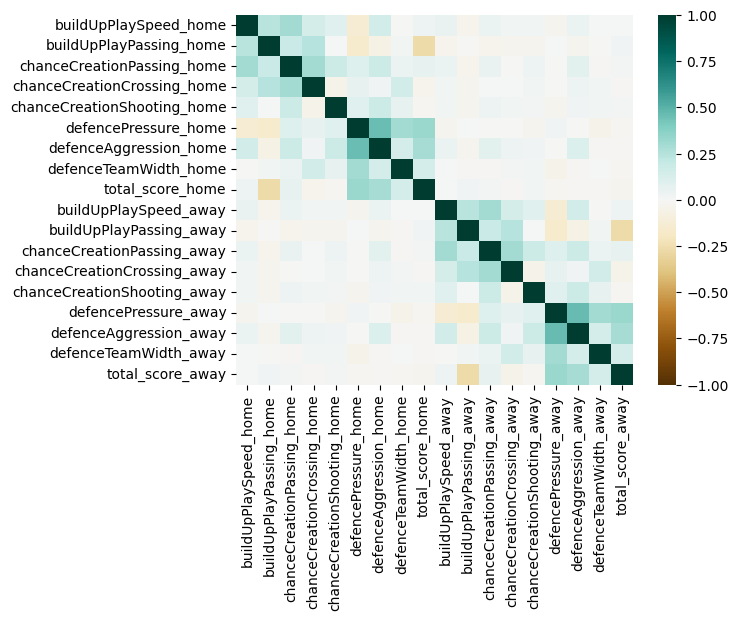

In [48]:
sns.heatmap(
    X_train.select_dtypes(include=[np.number]).corr(),
    vmin=-1,
    vmax=1,
    cmap="BrBG",
)

There are some moderate correlations, the biggest one being defence pressure x defence aggression.


In [49]:
pearson, pvalue = stats.pearsonr(
    X_train["defencePressure_home"], X_train["defenceAggression_home"]
)
print(f"Pearson coefficient for the home - away goals: {pearson:1.2f}")
print(f"p value for the test: {pvalue:1.3f}")

Pearson coefficient for the home - away goals: 0.46
p value for the test: 0.000


Since the biggest correlation between predictors is only moderate, we can assume there is no multicolinearity.


Let's establish our baseline model. We can try predicting the mean every time.


In [50]:
Y_predictions_home_baseline = np.ones((len(Y_test_home), 1)) * Y_train_home.mean()
print("Validation metrics of the baseline home model:")
print_validation_metrics(Y_test_home, Y_predictions_home_baseline)

Validation metrics of the baseline home model:
RMSE: 1.334
r2: -0.000


In [51]:
Y_predictions_away_baseline = np.ones((len(Y_test_away), 1)) * Y_train_away.mean()
print("Validation metrics of the baseline home model:")
print_validation_metrics(Y_test_away, Y_predictions_away_baseline)

Validation metrics of the baseline home model:
RMSE: 1.154
r2: -0.002


Now we can continue constructing the home and away models.


In [52]:
# fit scaler
scaler = StandardScaler()
X_train_numerical = X_train.select_dtypes(include=[np.number])
scaler.fit(X_train_numerical)
# scale and get dummies for X_train
X_train_transformed = transform_X(X_train, scaler)
# scale and get dummies for X_test
X_test_transformed = transform_X(X_test, scaler)
# NOTE! potentially, there could be an issue here. Getting dummies independently may yield very different results, especially when drop_first = True. Question - best way to handle this?

# fit linear regression model for home goals
model = LinearRegression()
model_home = model.fit(X_train_transformed, Y_train_home)
# validate the model
Y_predictions_home = model_home.predict(X_test_transformed)
print("Validation metrics of the home model:")
print_validation_metrics(Y_test_home, Y_predictions_home)

Validation metrics of the home model:
RMSE: 1.275
r2: 0.087


In [53]:
model_away = model.fit(X_train_transformed, Y_train_away)
Y_predictions_away = model_away.predict(X_test_transformed)

print("Validation metrics of the away model:")
print_validation_metrics(Y_test_away, Y_predictions_away)

Validation metrics of the away model:
RMSE: 1.122
r2: 0.052


Comparing with the baseline, we do improve, but not by much. We can also do some statistical inference and check which features are the most important.


In [54]:
model_home = sm.OLS(Y_train_home, sm.add_constant(X_train_transformed).astype(float))
results = model_home.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         home_team_goal   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     97.89
Date:                Fri, 28 Jul 2023   Prob (F-statistic):               0.00
Time:                        22:12:11   Log-Likelihood:                -37046.
No. Observations:               22862   AIC:                         7.415e+04
Df Residuals:                   22833   BIC:                         7.438e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

Looking at the coefficients, the most important feature is total_score. However, there's some unintuitive coefficients that could be accredited to the interactions between total_score and other features. The most evident strange interaction is that the 'buildUpPlayDribblingClass' features' coefficients are negative. In the EDA part we saw that the worst performing teams have little dribbling. The model is telling us the opposite - that those teams who have little dribbling actually score more goals, which could be the case but is strange. <br>
Let's try two additional things: what if the model only had the total score feature? What if it had everything except total_score?


In [55]:
# fit linear regression model for home goals
model_home = model.fit(X_train_transformed.filter(like="total_score"), Y_train_home)
# validate the model
Y_predictions_home = model_home.predict(X_test_transformed.filter(like="total_score"))
print("Validation metrics of the home model when only total_score is given:")
print_validation_metrics(Y_test_home, Y_predictions_home)

Validation metrics of the home model when only total_score is given:
RMSE: 1.283
r2: 0.076


In [56]:
X_train_transformed_except = X_train_transformed[
    X_train_transformed.columns.drop(
        list(X_train_transformed.filter(like="total_score"))
    )
]
X_test_transformed_except = X_test_transformed[
    X_test_transformed.columns.drop(list(X_test_transformed.filter(like="total_score")))
]
# fit linear regression model for home goals
model_home = model.fit(X_train_transformed_except, Y_train_home)
# validate the model
Y_predictions_home = model_home.predict(X_test_transformed_except)
print(
    "Validation metrics of the home model when all features except total_score are"
    " given:"
)
print_validation_metrics(Y_test_home, Y_predictions_home)

Validation metrics of the home model when all features except total_score are given:
RMSE: 1.297
r2: 0.054


We can see that model with only total_score performs slightly worse than the initial model. Model with all features except total_score struggles but still has some merit.


In [57]:
model_home = sm.OLS(
    Y_train_home, sm.add_constant(X_train_transformed_except).astype(float)
)
results = model_home.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         home_team_goal   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     40.28
Date:                Fri, 28 Jul 2023   Prob (F-statistic):          2.46e-199
Time:                        22:12:12   Log-Likelihood:                -37829.
No. Observations:               22862   AIC:                         7.571e+04
Df Residuals:                   22835   BIC:                         7.593e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

Even though this model performs worse, we can see some meaningful statistical inference:

<ul>
<li> Most of the features that correlated with performance as seen in the EDA part also influence our model in the same way.
<li> Some features, like chanceCreationShooting_away, have almost no influence over the goals scored by the home team.
<li> Lots of dribbling is better than Normal, which is better than Little.
<li> Free form positioning is better than Organised.
<li> Surprise here - Offside Trap defensive strategy is worse than Cover strategy.


Let's again fit our initial model and analyse it a bit more.


In [58]:
model_home = model.fit(X_train_transformed, Y_train_home)
Y_predictions_home = model_home.predict(X_test_transformed)

actual_vs_predicted = pd.DataFrame(
    [Y_test_home.reset_index(drop=True), Y_predictions_home]
).T
actual_vs_predicted.columns = ["Actual goals", "Predicted Goals"]
actual_vs_predicted.describe()

,Actual goals,Predicted Goals
count,2499.000000,2499.000000
mean,1.555822,1.528114
std,1.334245,0.463321
min,0.000000,0.215894
25%,1.000000,1.190562
50%,1.000000,1.526551
75%,2.000000,1.845194
max,10.000000,3.059654


The model fairly accurately reaches the mean, min, quartile targets, but fails in reaching the standard deviation. Most importantly - it never actually predicts goals to be zero or more than 3. Also, up until now we ignored the fact that our model is continuous, while the target is discrete.<br>
Let's setup a new baseline model where we predict the median rather than the mean.


In [59]:
Y_predictions_home_baseline = np.ones((len(Y_test_home), 1))
print("Validation metrics of the new baseline model:")
print_validation_metrics(Y_test_home, Y_predictions_home_baseline)

Validation metrics of the new baseline model:
RMSE: 1.445
r2: -0.174


In [60]:
Y_predictions_home_rounded = np.rint(Y_predictions_home)
actual_vs_predicted["Rounded Predictions"] = Y_predictions_home_rounded
print("Validation metrics of the rounded home model:")
print_validation_metrics(Y_test_home, Y_predictions_home_rounded)

Validation metrics of the rounded home model:
RMSE: 1.302
r2: 0.047


When the output is rounded, our model's performance deteriorates. However, the new baseline model is also worse than the previous.


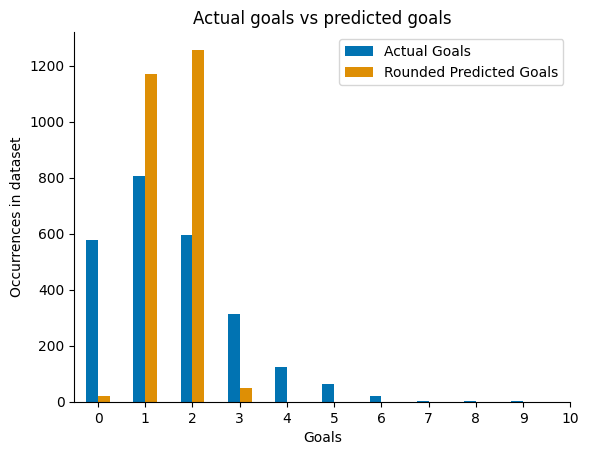

In [61]:
df = pd.concat(
    [
        pd.Series(Y_test_home).value_counts(),
        pd.Series(Y_predictions_home_rounded).value_counts(),
    ],
    axis=1,
    sort=True,
)
df.columns = ["Actual Goals", "Rounded Predicted Goals"]

df.plot(kind="bar", color=figure_colors_qualitative, xticks=list(range(11)), rot=0)
plt.title("Actual goals vs predicted goals")
plt.xlabel("Goals")
plt.ylabel("Occurrences in dataset")
sns.despine()

The model clearly condensed around the mean too much. There's barely any 0 or 3 goal predictions and no predictions over 3 goals.


#### Using logistic regression to predict goals count


Until now we tried to predict the goal count using linear regression. we could also try using logistic regression. However, since there is a very small representation of matches with 4 or more goals, we will bin all goals over 3 into the "3" group.


In [62]:
# all goals over 3 will be set to "3"
Y_train_home_class = Y_train_home.copy()
Y_train_home_class[Y_train_home_class > 3] = 3

# fit logistic regression model
model = LogisticRegression(multi_class="multinomial", solver="lbfgs").fit(
    X_train_transformed, Y_train_home_class
)
# validate the model
Y_predictions = model.predict(X_test_transformed)
print(classification_report(Y_test_home, Y_predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.35      0.15      0.21       577
           1       0.33      0.67      0.44       805
           2       0.19      0.04      0.06       594
           3       0.20      0.32      0.24       314
           4       0.00      0.00      0.00       123
           5       0.00      0.00      0.00        63
           6       0.00      0.00      0.00        19
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1

    accuracy                           0.30      2499
   macro avg       0.11      0.12      0.09      2499
weighted avg       0.25      0.30      0.23      2499



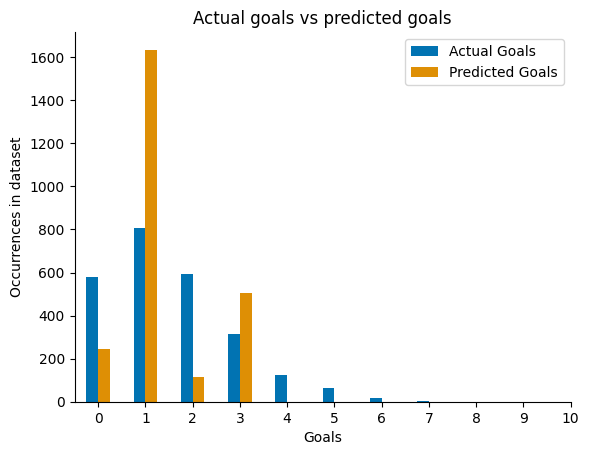

In [63]:
df = pd.concat(
    [
        pd.Series(Y_test_home).value_counts(),
        pd.Series(Y_predictions).value_counts(),
    ],
    axis=1,
    sort=True,
)
df.columns = ["Actual Goals", "Predicted Goals"]

df.plot(kind="bar", color=figure_colors_qualitative, xticks=list(range(11)), rot=0)
plt.title("Actual goals vs predicted goals")
plt.xlabel("Goals")
plt.ylabel("Occurrences in dataset")
sns.despine()

Accuracy of 0.3 is quite low, lower than just guessing "1" all the time (then we would be right 32% of the time). From the above figure we also see how the model misinterprets the data. It is not easy to predict the goals count.


### Can we predict which team will win the match?


#### Binomial logistic regression


We'll use the team data from the "how many goals scored?" model. We only need to create a Y vector for who won. Let's see the proportions of game endings in the train dataset.


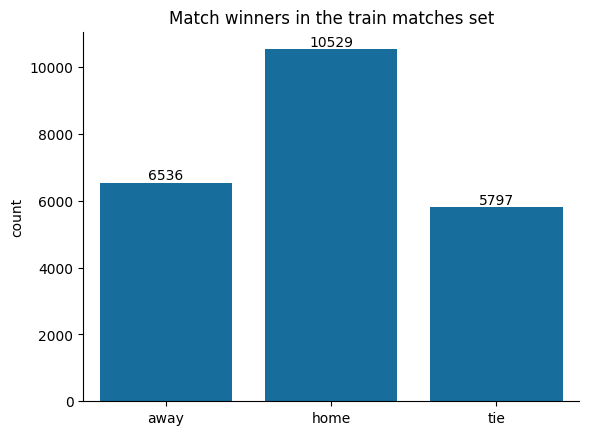

In [64]:
def who_won(row):
    if row["home_team_goal"] > row["away_team_goal"]:
        return "home"
    elif row["home_team_goal"] < row["away_team_goal"]:
        return "away"
    else:
        return "tie"


sns.countplot(x=Y_train.apply(who_won, axis=1), color=figure_colors_qualitative[0])
plt.title("Match winners in the train matches set")
for container in plt.gca().containers:
    plt.gca().bar_label(container)
sns.despine()

Most of the time match ends in a home win. To make the problem as simple as possible, we can start by predicting whether home will win or not. Let's also compute the % of home wins to use as baseline accuracy.


In [65]:
Y_train_home_won = Y_train["home_team_goal"] > Y_train["away_team_goal"]
Y_test_home_won = Y_test["home_team_goal"] > Y_test["away_team_goal"]
print(
    "Proportion of home wins in the train dataset:"
    f" {Y_train_home_won.sum()/Y_train_home_won.count()*100:.1f}%"
)

Proportion of home wins in the train dataset: 46.1%


              precision    recall  f1-score   support

       False       0.64      0.76      0.69      1401
        True       0.60      0.46      0.52      1098

    accuracy                           0.63      2499
   macro avg       0.62      0.61      0.61      2499
weighted avg       0.62      0.63      0.62      2499



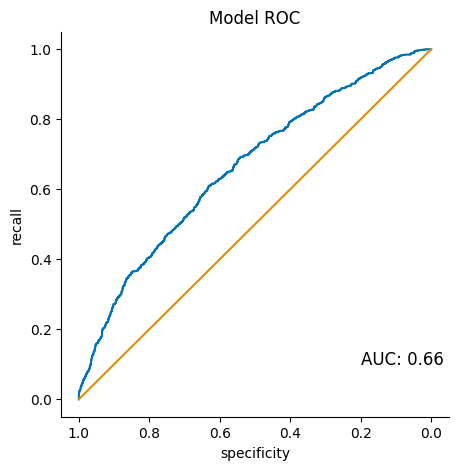

In [66]:
# fit logistic regression model
model_binomial = LogisticRegression(
    solver="liblinear", class_weight={0: 1.0, 1: 1.0}, penalty="l2", C=1e-4
).fit(X_train_transformed, Y_train_home_won)
# validate the model
paint_roc_figure(model_binomial, Y_test_home_won, X_test_transformed, True, 1)
Y_predictions = model_binomial.predict(X_test_transformed)
print(classification_report(Y_test_home_won, Y_predictions))

In this simple problem, we quite clearly beat the baseline with AUC=0.66 and accuracy=0.63 (when threshold is 0.5)<br>
However, we may be more interested in the precision characteristic of the model, since having a high precision model would increase the chance to win a bet.


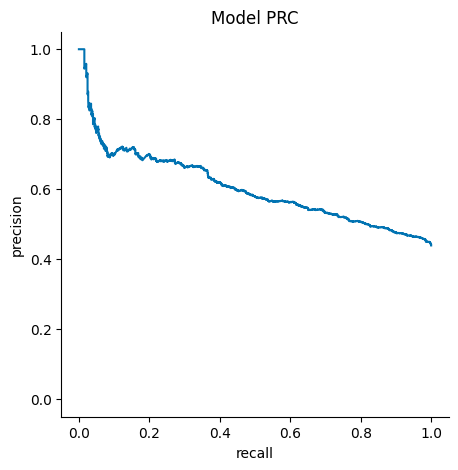

In [67]:
paint_prc_figure(model_binomial, Y_test_home_won, X_test_transformed, True, 1)

As we can see, we can have a very precise model, but recall will suffer.


#### Multinomial logistic regression


Next, let's try multinomial logistic regression. this time, we will be predicting whether the game ends in a tie, home win or away win.


              precision    recall  f1-score   support

        away       0.44      0.45      0.45       763
        home       0.51      0.79      0.62      1098
         tie       0.30      0.00      0.01       638

    accuracy                           0.49      2499
   macro avg       0.42      0.42      0.36      2499
weighted avg       0.43      0.49      0.41      2499



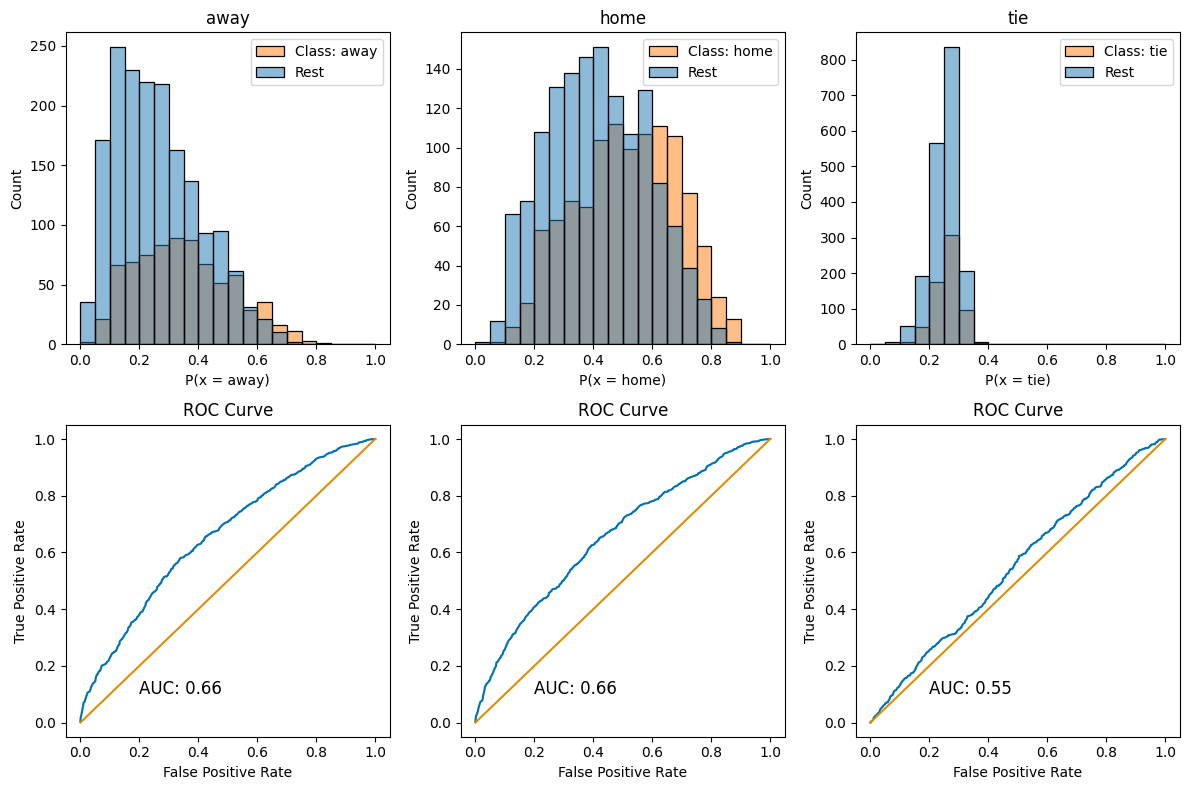

In [68]:
Y_train_class = Y_train.apply(who_won, axis=1)
Y_test_class = Y_test.apply(who_won, axis=1)

model_multinomial = LogisticRegression(multi_class="multinomial", solver="lbfgs").fit(
    X_train_transformed, Y_train_class
)

Y_predictions = model_multinomial.predict(X_test_transformed)
print(classification_report(Y_test_class, Y_predictions))
plot_multiclass_roc(model_multinomial, X_test_transformed, Y_test_class)

With threshold=0.5, we achieve accuracy=0.49. This beats the random guessing - guessing home every time would get us 0.44. Still, predicting the outcome isn't easy. Our last model can predict home and away wins with some accuracy, but ties are another story.


#### Using models to win money


To prove our models can win money we can utilise the betting odds data in the Match table. Let's imagine that before each match in the test set we check what our model predicts and then compare the odds at different betting companies. We'll want to invest 1$ in that company which gives the best odds.<br>
For a start, let's test out our last, multiclass model.


In [69]:
# get odds
home_odds = duckdb.query(f"""
SELECT id, COLUMNS('.*H$')
FROM Match
""").to_df()
tie_odds = duckdb.query(f"""
SELECT id, COLUMNS('.*D$')
FROM Match
""").to_df()
away_odds = duckdb.query(f"""
SELECT id, COLUMNS('.*A$')
FROM Match
""").to_df()
home_odds = home_odds.set_index("id")
away_odds = away_odds.set_index("id")
tie_odds = tie_odds.set_index("id")

# construct dataframe with predictions, real outcomes, max odds and earnings
df = pd.DataFrame([Y_test_class]).T.rename(columns={0: "outcome"})
df["prediction"] = Y_predictions

# we'll bet in the agency that has best odds
df["max_home_odds"] = home_odds.max(axis=1)
df["max_away_odds"] = away_odds.max(axis=1)
df["max_tie_odds"] = tie_odds.max(axis=1)

# we'll invest a dollar in each match
df = df.dropna()
investment = len(df)

# calculate if and how much we won
df["earnings"] = 0
df["bet_won"] = df["outcome"] == df["prediction"]
home_bets_won = df["bet_won"] & (df["prediction"] == "home")
away_bets_won = df["bet_won"] & (df["prediction"] == "away")
tie_bets_won = df["bet_won"] & (df["prediction"] == "tie")
df.loc[home_bets_won, "earnings"] = df["max_home_odds"]
df.loc[away_bets_won, "earnings"] = df["max_away_odds"]
df.loc[tie_bets_won, "earnings"] = df["max_tie_odds"]
earnings = df["earnings"].sum()

# let's see the summary
print(
    f"We invested {investment}$ and earned {earnings:.2f}$, at a loss of"
    f" {investment - earnings:.2f}$"
)

We invested 2255$ and earned 2229.86$, at a loss of 25.14$


We invested in 2255 matches and in total lost 25 dollars. We know that our model doesn't do very well predicting ties. Perhaps we can skip those matches where our model predicts a tie?


In [70]:
df_no_ties = df[df["prediction"].isin(["home", "away"])]
investment = len(df_no_ties)
earnings = df_no_ties["earnings"].sum()
print(
    f"We invested {investment}$ and earned {earnings:.2f}$, at a loss of"
    f" {investment - earnings:.2f}$"
)

We invested 2245$ and earned 2220.15$, at a loss of 24.85$


Unfortunately, ties are predicted very rarely and the performance doesn't improve too much. We can try out the binomial model. Let's invest in those matches that our models predicts as 'home win' and skip the others.


In [71]:
df_binomial = df.copy()
# get X_test with index of our betting df
X_test_viable_bet = X_test_transformed[X_test_transformed.index.isin(df_binomial.index)]
# get predictions
df_binomial["prediction"] = model_binomial.predict(X_test_viable_bet)
# filter for "home won" predictions
df_binomial = df_binomial[df_binomial["prediction"]]

df_binomial["earnings"] = 0
bets_won = df_binomial["outcome"] == "home"
df_binomial.loc[bets_won, "earnings"] = df_binomial["max_home_odds"]

investment = len(df_binomial)
earnings = df_binomial["earnings"].sum()
print(
    f"We invested {investment}$ and earned {earnings:.2f}$, at a loss of"
    f" {investment - earnings:.2f}$"
)

We invested 766$ and earned 745.25$, at a loss of 20.75$


The proportion is even worse! Perhaps we can use some other threshold than the default 0.5 and perform better? Let's check what's the best threshold using our training data.


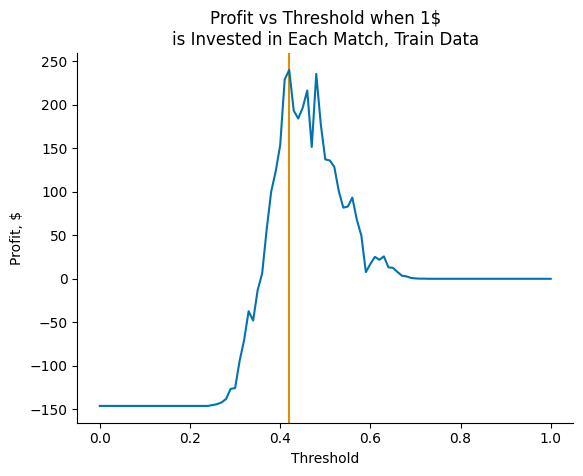

In [72]:
def calculate_profit(df_raw):
    df = df_raw.copy()
    # filter out all non home-win predictions
    df = df[df["prediction"]]

    # locate won bets and calculate individual earnings
    df["earnings"] = 0
    bets_won = df["outcome"] == "home"
    df.loc[bets_won, "earnings"] = df["max_home_odds"]

    # calculate profit
    investment = len(df)
    earnings = df["earnings"].sum()
    return earnings - investment


# construct dataframe with real outcomes and max odds
betting_train = pd.DataFrame([Y_train_class]).T.rename(columns={0: "outcome"})

# we'll bet in the agency that has best odds
betting_train["max_home_odds"] = home_odds.max(axis=1)
betting_train["max_away_odds"] = away_odds.max(axis=1)
betting_train["max_tie_odds"] = tie_odds.max(axis=1)

# drop rows that have no odds
betting_train = betting_train.dropna()

# get X_train with index of our betting df
X_train_viable_bet = X_train_transformed[
    X_train_transformed.index.isin(betting_train.index)
]

# calculate profit at each threshold
profits_dict = {}
for threshold in np.arange(0, 1.01, 0.01):
    # get predictions
    betting_train["prediction"] = (
        model_binomial.predict_proba(X_train_viable_bet)[:, 1] >= threshold
    )
    profits_dict[threshold] = calculate_profit(betting_train)

# locate best threshold, mark it on the figure
max_profit_idx = np.array(list(profits_dict.values())).argmax()
best_threshold = list(profits_dict.keys())[max_profit_idx]
plt.axvline(best_threshold, color=figure_colors_qualitative[1])

# plot profit vs threshold
sns.lineplot(profits_dict, color=figure_colors_qualitative[0])
plt.title("Profit vs Threshold when 1$\nis Invested in Each Match, Train Data")
plt.xlabel("Threshold")
plt.ylabel("Profit, $")
sns.despine()

If we could bet on the past games, we would definitely make a profit with our model. Let's plot the same figure for the test set.


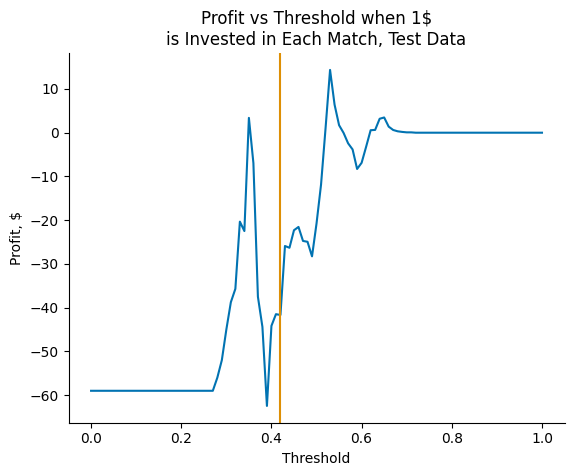

In [73]:
betting_test = df.copy()
# get X_test with index of our betting df
X_test_viable_bet = X_test_transformed[
    X_test_transformed.index.isin(betting_test.index)
]

# calculate profit at each threshold
profits_dict = {}
for threshold in np.arange(0, 1.01, 0.01):
    # get predictions
    betting_test["prediction"] = (
        model_binomial.predict_proba(X_test_viable_bet)[:, 1] >= threshold
    )
    profits_dict[threshold] = calculate_profit(betting_test)

# plot profit vs threshold
sns.lineplot(profits_dict, color=figure_colors_qualitative[0])
plt.axvline(best_threshold, color=figure_colors_qualitative[1])
plt.title("Profit vs Threshold when 1$\nis Invested in Each Match, Test Data")
plt.xlabel("Threshold")
plt.ylabel("Profit, $")
sns.despine()

We can see that most of the time we're in negative profit territory, there's just a few thresholds that would net a positive profit. Also, the 'best threshold' selected from training data performs even worse than the default 0.5. Unfortunately, our betting game ends in a failure.


## Bonus Challenge


Let's try clustering teams attributes to see similarities between well-performing and bad-performing teams. To narrow down the list of teams, let's only use UK teams.


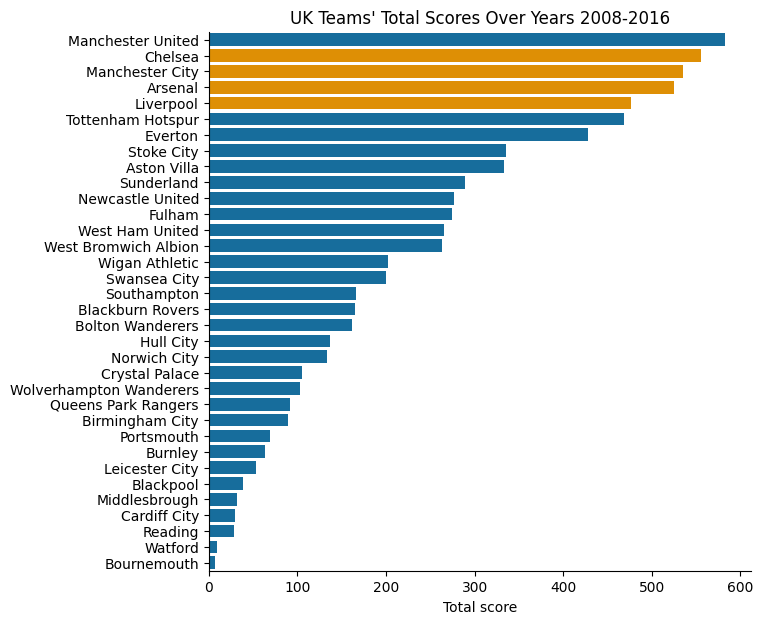

In [74]:
# get UK teams ids and names
UK_teams = duckdb.query("""
SELECT DISTINCT M.home_team_api_id AS 'team_api_id', T.team_long_name AS 'team'
FROM League L
JOIN Match M
ON M.league_id = L.id
JOIN Team T
ON T.team_api_id = M.home_team_api_id
WHERE L.name = 'England Premier League'
""").to_df().set_index("team_api_id")

# filter team data for only UK, save score separately, use only int features because clustering needs numeric
UK_team_data = important_team_data[important_team_data["team_api_id"].isin(UK_teams.index)].set_index("team_api_id")
UK_team_data["team"] = UK_teams["team"]
UK_team_data = UK_team_data.set_index("team")
UK_team_scores = UK_team_data["total_score"]
UK_team_data = UK_team_data.select_dtypes(int)

# cluster using plotly dendrogram
fig = ff.create_dendrogram(UK_team_data, orientation='left', labels=UK_team_data.index)
fig.update_layout(width=800, height=800)
fig.show()

# plot teams' total scores to see which are performing well and which not so much
plt.figure(figsize=(7,7))
UK_team_scores = UK_team_scores.sort_values(ascending=False)
sns.barplot(x=UK_team_scores, y=UK_team_scores.index, color=figure_colors_qualitative[0])
plt.title("UK Teams' Total Scores Over Years 2008-2016")
plt.ylabel("")
plt.xlabel("Total score")
# highlight well-performing teams that are nearby in a cluster
for idx in [1,2,3,4]:
    plt.gca().patches[idx].set_facecolor(figure_colors_qualitative[1])
sns.despine()

We received some clusters, and one of the clusters contains 4 top teams - marked in orange. That could mean that well-performing teams have something in common. Then again, Manchester United's closest neighbor is Bournemouth, which isn't a very good team.

# Conclusions


We performed EDA using DuckDB to query the database, pandas to store and manipulate the data, seaborn and matplotlib - to visualise the data.
For statistical inference we utilised statsmodels and scipy. After hypothesis testing we are fairly certain that there is such a thing as home advantage.
We created some linear machine learning models to predict goals scored and the outcome of a football match. The best model for goals scored is just a bit better than random guessing, while the best model for match outcome prediction achieved 0.49 accuracy, with AUC 0.66 for home and away wins prediction. Ties are much harder to predict.
After trying to use the models for betting game it is quite clear that betting on football matches is going to be risky. We didn't manage to get a positive income however hard we tried. Judging from these results, betting on football is not a good business model.

There are some things left to do and explore:
<ol>
    <li> Explore the player attributes, use them for modelling.
    <li> Don't use the latest team (or player) attributes for modelling. It should be more accurate to train with those attributes that are the most up-to-date at the time of the match.
    <li> total_score metric may be the best one we had in this project, but it could be improved. It could instead be score per league, since teams can migrate from a lower league to the top and vice-versa. For example, Bournemouth only played in 2016.
    <li> Use ordinal regression for goals scored, explore other models, not necessarily linear.
    
</ol>
Google Looker Studio dashboard can be found here: https://lookerstudio.google.com/reporting/51d1f099-c5bd-4dbf-96fd-f2db227abac2